In [1]:
import pandas as pd
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
res_dir = 'res'
experiments = ['mrcv_mites','mrcv_all','sun_all','sun_mites']
#experiments = ['sun_all','sun_mites']
#res_dir = 'all_res'
path = '../data/shortstack/%s/Results.txt'
path_annotation = '../data/introns.gff3'
path_annotation_promoters = '../data/promoters.gff3'
path_mites = "../data/res/mites_consensus.fasta"
path_mites_res = '../data/res/mites_prod.fasta'
path_res = '../data/res/all_results.csv'
path_mirna_seq = '../data/res/mirna.y.fasta'
path_mirna_seq_trep = '../data/res/mirna.y.trep.fasta'
path_mirna_mites_seq = '../data/res/mirna.mites.y.fasta'
path_mirna_mature = '../data/res/mirna.y.mature.csv'
path_res_seq = '../data/res/all_results.fasta'

path_genome = '../data/Triticum_aestivum.IWGSC.dna.toplevel.fa'
path_blast_res_mirna_mites = '../data/res/blast_mirna_mites.csv'
path_blast_res_mites_mirna = '../data/res/blast_mites_mirna.csv'



path_mirbase = '../data/mature.fa'

In [3]:
### Load shortstack results
dfs = {}
for experiment in experiments:
    experiment_path = path % (experiment,)
    df = pd.read_csv(experiment_path, sep='\t')
    df['Name'] = experiment + '_' + df['Name']
    print('Experiment:', experiment)
    print('All results:',len(df.index))
    #df = df[df.MIRNA == 'Y']
    #print('Only miRNAs:',len(df.index))
    df = df[df.Reads > 10]
    print('Only hotspots with +10 reads:',len(df.index))
    #df = df[df['21'] > 5]
    #print('Only miRNAs 21nt +5 reads:',len(df.index))
    print('*' * 10)
    dfs[experiment] = df

Experiment: mrcv_mites
All results: 1211339
Only hotspots with +10 reads: 37695
**********
Experiment: mrcv_all
All results: 38532
Only hotspots with +10 reads: 38532
**********
Experiment: sun_all
All results: 157492
Only hotspots with +10 reads: 157492
**********
Experiment: sun_mites
All results: 1211339
Only hotspots with +10 reads: 78708
**********


In [4]:
dfs = [ v for v in dfs.values() ]

In [5]:
df = pd.concat(dfs)

In [6]:
len(df.index)

312427

In [7]:
df.head(2)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,DicerCall,MIRNA,PhaseScore,Short,Long,20,21,22,23,24
104,1A:1195670-1195768,mrcv_mites_MITE_T_102265|chr6B|218219330|21821...,99,23,0.181,15,0.783,.,AAUGUAAGAUGUUUUUUUGACACU,7,...,24,N6,0.0,0,0,0,0,1,6,16
111,1A:1239059-1239290,mrcv_mites_MITE_T_45812|chr5A|568401370|568401...,232,30,0.235,7,0.833,+,GAGGACGCACUAUAUUUUAGAACG,12,...,24,N14,-1.0,0,4,0,0,0,1,25


In [8]:
#rename correctly all loci

In [9]:
df['Name'] = df['Name'].str.split('|').str[0]

In [10]:
df.head(2)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,DicerCall,MIRNA,PhaseScore,Short,Long,20,21,22,23,24
104,1A:1195670-1195768,mrcv_mites_MITE_T_102265,99,23,0.181,15,0.783,.,AAUGUAAGAUGUUUUUUUGACACU,7,...,24,N6,0.0,0,0,0,0,1,6,16
111,1A:1239059-1239290,mrcv_mites_MITE_T_45812,232,30,0.235,7,0.833,+,GAGGACGCACUAUAUUUUAGAACG,12,...,24,N14,-1.0,0,4,0,0,0,1,25


In [11]:
df['seqname'] = df['#Locus'].str.split(':').str[0]
df['position'] = df['#Locus'].str.split(':').str[1]
df['start'] = df.position.str.split('-').str[0].astype(int)
df['end'] = df.position.str.split('-').str[1].astype(int)

In [12]:
df['Name'] = df['Name'] + '_' + df['seqname'] + '_' + df['start'].astype(str) + '_' + df['end'].astype(str)

In [13]:
df.head(2)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,Long,20,21,22,23,24,seqname,position,start,end
104,1A:1195670-1195768,mrcv_mites_MITE_T_102265_1A_1195670_1195768,99,23,0.181,15,0.783,.,AAUGUAAGAUGUUUUUUUGACACU,7,...,0,0,0,1,6,16,1A,1195670-1195768,1195670,1195768
111,1A:1239059-1239290,mrcv_mites_MITE_T_45812_1A_1239059_1239290,232,30,0.235,7,0.833,+,GAGGACGCACUAUAUUUUAGAACG,12,...,4,0,0,0,1,25,1A,1239059-1239290,1239059,1239290


In [14]:
df[df.duplicated(['Name'],keep=False)]

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,Long,20,21,22,23,24,seqname,position,start,end


In [15]:
df = df.reset_index(drop=True)


In [16]:
print(len(df.index))

312427


In [17]:
df[df.index.isin(['876749','876750','876751','27433'])]

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,Long,20,21,22,23,24,seqname,position,start,end
27433,5D:531473775-531473940,mrcv_mites_MITE_T_61681_5D_531473775_531473940,166,16,0.126,2,0.5,.,UUCUAGAGAUCUCAACAAAUGACU,2,...,0,0,1,0,1,14,5D,531473775-531473940,531473775,531473940


In [18]:
df_sep = {}
for seqname in df.seqname.unique():
    df_sep[seqname] = df[df.seqname == seqname]


In [19]:
min_distance = 150
duplicated = []
for k,v in df.iterrows():
    if k in duplicated:
        continue
    other = df_sep[v.seqname]
    other = other[(other.index != k) & 
                (other.MajorRNA == v.MajorRNA) &
                (abs(other.start - v.start) <= min_distance) & 
                (abs(other.end - v.end) <= min_distance)]
    if len(other.index) > 0:
        duplicated += other.index.tolist()

In [20]:
duplicated = set(duplicated)
print(len(duplicated))

31536


In [21]:
print(len(df.index))

312427


In [22]:
df = df[~df.index.isin(duplicated)]
count_total = len(df.index)
count_total

280891

In [23]:
df.MIRNA.value_counts()

N6     163879
N11     53007
N5      22553
N2      18426
N14      7355
N13      4901
N12      4763
N15      2081
N3       1834
N4       1576
Y         270
N8        246
Name: MIRNA, dtype: int64

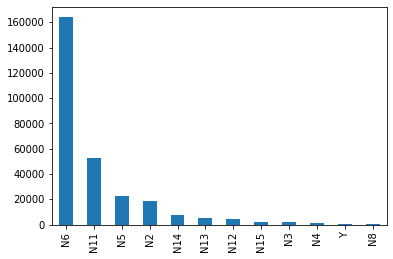

In [24]:
df.MIRNA.value_counts().plot(kind='bar')

In [27]:
df_ = df

In [28]:
df = df_[df_.MIRNA == 'N15']
print('Only miRNAs:',len(df.index))

Only miRNAs: 2081


In [29]:
 df.groupby('DicerCall').count()['Name']

DicerCall
20      42
21     829
22     107
23      15
24    1088
Name: Name, dtype: int64

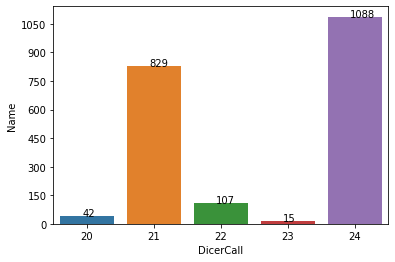

In [30]:
df_plot = df.groupby('DicerCall').count()
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot
ax = sns.barplot(x = df_plot.index, y = df_plot.Name)
x_offset = -0.07
y_offset = 0.15
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for p in ax.patches:
    b = p.get_bbox()
    val = int(b.y1)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
ax
pyplot.savefig('../data/res/mirna_sizes.png',transparent=True, bbox_inches='tight', pad_inches=0)

In [31]:
df.head(3)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,Long,20,21,22,23,24,seqname,position,start,end
15,1A:4307025-4307398,mrcv_mites_MITE_T_6051_1A_4307025_4307398,374,11,0.086,2,0.182,-,CCUCGAUAGAUCGACGGAGCGCCU,7,...,0,0,0,0,0,11,1A,4307025-4307398,4307025,4307398
25,1A:7191963-7192334,mrcv_mites_MITE_T_7077_1A_7191963_7192334,372,65,0.510,4,0.031,-,UUUUUUGUCGAGAGUUGCUCA,36,...,0,13,38,0,0,10,1A,7191963-7192334,7191963,7192334
138,1A:25815806-25815934,mrcv_mites_MITE_T_82172_1A_25815806_25815934,129,12,0.094,1,0.083,-,CCGGAAAUACUUGUUUUAGAAAUG,7,...,0,0,0,0,1,11,1A,25815806-25815934,25815806,25815934


In [32]:
#######################
####  CHECKPOINT  #####
#######################

In [33]:
# SAVE CURRENT STATE

df.to_csv('../data/res/checkpoint1.csv', index=None)


In [34]:
# LOAD PREVIOUS STATE
df = pd.read_csv('../data/res/checkpoint1.csv')
print(len(df.index))
df.head(2)

2081


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,Long,20,21,22,23,24,seqname,position,start,end
0,1A:4307025-4307398,mrcv_mites_MITE_T_6051_1A_4307025_4307398,374,11,0.086,2,0.182,-,CCUCGAUAGAUCGACGGAGCGCCU,7,...,0,0,0,0,0,11,1A,4307025-4307398,4307025,4307398
1,1A:7191963-7192334,mrcv_mites_MITE_T_7077_1A_7191963_7192334,372,65,0.510,4,0.031,-,UUUUUUGUCGAGAGUUGCUCA,36,...,0,13,38,0,0,10,1A,7191963-7192334,7191963,7192334


In [35]:
#######################
##  END CHECKPOINT  ###
#######################

In [36]:
df_mites = df[df.Name.str.contains('MITE')]
count_mites = len(df_mites.index)
count_mites

1346

In [37]:
df_nomites = df[~df.Name.str.contains('MITE')]
count_nomites = len(df_nomites.index)
count_nomites

735

In [38]:
#get sequences
df.sort_values(['seqname', 'start'], inplace=True)


In [44]:
fasta_seq = SeqIO.parse(path_genome, 'fasta')
   

In [45]:
buffer_seqs = []
sizes = []
for record in fasta_seq:
    dff_extract = df[df.seqname == record.id]
    print(record.id, len(dff_extract.index))
    clean_seq = ''.join(str(record.seq).splitlines())
    for k,v in dff_extract.iterrows():
        start = min(v.start,v.end)
        end = max(v.start,v.end)
        sizes.append(abs(start - end))
        new_seq = clean_seq[start:end]
        id = v.Name
        desc = record.id + "_" + str(start) + '_' + str(end)
        seq = SeqRecord(Seq(new_seq), id=id, description=desc)
        buffer_seqs.append(seq)
SeqIO.write(buffer_seqs, path_res_seq, "fasta")
print(path_res_seq)

1A 92
1B 84
1D 66
2A 107
2B 115
2D 78
3A 92
3B 112
3D 89
4A 104
4B 77
4D 81
5A 116
5B 128
5D 105
6A 99
6B 109
6D 72
7A 114
7B 116
7D 102
Un 23
../data/res/all_results.fasta


In [46]:
sum(sizes ) / len(sizes)

188.27775108121097

In [47]:
max(sizes)

997

In [48]:
min(sizes)

20

In [49]:
path_res_seq

'../data/res/all_results.fasta'

,MIRNA
1350,N15


In [53]:
cmd = "blastn -evalue 1e-3 -task blastn -subject data/res/all_results.fasta -query  data/res/mites_consensus.fasta -outfmt '6 qseqid sseqid qstart qend sstart send mismatch gaps pident evalue length qlen slen qcovs score'  > %s"
cmd % (path_blast_res_mirna_mites.replace('../',''))

"blastn -evalue 1e-3 -task blastn -subject data/res/all_results.fasta -query  data/res/mites_consensus.fasta -outfmt '6 qseqid sseqid qstart qend sstart send mismatch gaps pident evalue length qlen slen qcovs score'  > data/res/blast_mirna_mites.csv"

In [54]:
cmd = "blastn -evalue 1e-3 -task blastn -query data/res/all_results.fasta -subject  data/res/mites_consensus.fasta -outfmt '6 qseqid sseqid qstart qend sstart send mismatch gaps pident evalue length qlen slen qcovs score'  >  %s"
cmd % (path_blast_res_mites_mirna.replace('../',''))

"blastn -evalue 1e-3 -task blastn -query data/res/all_results.fasta -subject  data/res/mites_consensus.fasta -outfmt '6 qseqid sseqid qstart qend sstart send mismatch gaps pident evalue length qlen slen qcovs score'  >  data/res/blast_mites_mirna.csv"

In [55]:
df_ = df

In [56]:
df_trep = pd.read_csv(path_blast_res_mirna_mites, sep="\t")
cols = ['qseqid','sseqid','qstart','qend','sstart','send','mismatch','gaps','pident','evalue','length','qlen','slen','qcovs','score']
df_trep.columns = cols
df_trep = df_trep[df_trep.pident >= 80]
df_trep = df_trep[(df_trep.length / df_trep.slen) >= 0.8]
#df_trep = df_trep[df_trep.qcovs >= 80]
print(len(df_trep.index))
df_trep.head(2)

20452


,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
5,MITE_0,sun_mites_MITE_T_9379_2B_382730282_382730551,31,299,269,1,41,4,83.395,1.660000e-74,271,331,269,82,301
13,MITE_2,mrcv_mites_MITE_T_52748_4D_447638090_447638264,9,179,3,174,24,1,85.465,2.440000e-51,172,228,174,91,215


In [57]:
df_trep_2 = pd.read_csv(path_blast_res_mites_mirna, sep="\t")
cols = ['sseqid','qseqid','qstart','qend','sstart','send','mismatch','gaps','pident','evalue','length','qlen','slen','qcovs','score']
df_trep_2.columns = cols
df_trep_2 = df_trep_2[df_trep_2.pident >= 80]
df_trep_2 = df_trep_2[(df_trep_2.length / df_trep_2.slen) >= 0.8]
#df_trep = df_trep[df_trep.qcovs >= 80]
print(len(df_trep_2.index))
df_trep_2.head(2)

19479


,sseqid,qseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
44,sun_mites_MITE_T_64320_1A_3591931_3592092,DTT_Null_Thalos_consensus-1,7,159,6,158,17,2,87.662,1.420000e-48,154,161,158,95,205
46,sun_mites_MITE_T_64320_1A_3591931_3592092,DTT_Taes_Thalos_BQ484001-1,7,159,156,1,17,5,85.987,7.360000e-46,157,161,161,95,194


In [58]:
df_trep = pd.concat([df_trep,df_trep_2])

In [59]:
df_trep.qseqid.nunique()

786

In [60]:
df_trep.sseqid.nunique()

1507

In [61]:
#get the best MITE for each cluster

In [62]:
df_trep = df_trep[['qseqid','sseqid','score']]
df_trep.rename(columns={'qseqid':'MITE','sseqid':'cluster'}, inplace=True)

In [63]:
for cluster in list(df_trep.cluster.unique()):
    other = df_trep[df_trep.cluster == cluster]
    dtt = other[other.MITE.str.contains('DTT')]
    if len(dtt.index) > 0:
        df.loc[df.Name == cluster, 'MITE'] = dtt.loc[dtt['score'].idxmax()].MITE
    else:
        tracker = other[other.MITE.str.contains('MITE_')]
        if len(tracker.index) > 0:
            df.loc[df.Name == cluster, 'MITE'] = tracker.loc[tracker['score'].idxmax()].MITE


In [64]:
#df.drop("qseqid", axis=1, inplace=True)

In [65]:
total_count = len(df.index)
total_count

2081

In [66]:
df_new_not_mites = df[df.MITE.isnull()]
count_not_mites = len(df_new_not_mites.index)
count_not_mites

574

In [67]:
df_new_mites = df[df.MITE.notnull()]
count_mites = len(df_new_mites.index)
count_mites

1507

In [68]:
count_mites * 100 / total_count

72.41710716001923

In [56]:
df.head(2)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,20,21,22,23,24,seqname,position,start,end,MITE
264,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,...,0,1,0,1,14,1A,117385432-117385825,117385432,117385825,MITE_524
0,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.000,+,UAGAGAUUUCAAAUGGAACAC,7,...,2,9,0,0,3,1A,169645857-169646029,169645857,169646029,DTT_Tdur_Thalos_103H9-1


In [70]:
df.to_csv('../data/n15.csv', sep=',', index=None)

In [57]:
#######################
####  CHECKPOINT  #####
#######################

In [58]:
# SAVE CURRENT STATE
df.to_csv('../data/res/checkpoint2.csv', index=None)
print(len(df.index))
df.head(2)

270


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,20,21,22,23,24,seqname,position,start,end,MITE
264,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,...,0,1,0,1,14,1A,117385432-117385825,117385432,117385825,MITE_524
0,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.000,+,UAGAGAUUUCAAAUGGAACAC,7,...,2,9,0,0,3,1A,169645857-169646029,169645857,169646029,DTT_Tdur_Thalos_103H9-1


In [151]:
# LOAD PREVIOUS STATE
df = pd.read_csv('../data/res/checkpoint2.csv')
print(len(df.index))
df.head(2)

270


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,20,21,22,23,24,seqname,position,start,end,MITE
0,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,...,0,1,0,1,14,1A,117385432-117385825,117385432,117385825,MITE_524
1,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.000,+,UAGAGAUUUCAAAUGGAACAC,7,...,2,9,0,0,3,1A,169645857-169646029,169645857,169646029,DTT_Tdur_Thalos_103H9-1


In [152]:
#######################
##  END CHECKPOINT  ###
#######################

In [153]:
#mirbase

In [6]:
buffer_seqs = []
alls = {}
for k,v in df.iterrows():
    if v.Name in alls:
        print(v.Name)
    alls[v.Name] = 1
    desc = v['#Locus']
    seq = SeqRecord(Seq(v.MajorRNA), id=v.Name, description="")
    buffer_seqs.append(seq)
SeqIO.write(buffer_seqs, path_mirna_seq, "fasta")
print(len(buffer_seqs))
print(path_mirna_seq)

270
../data/res/mirna.y.fasta


In [7]:
buffer_seqs = []
for k,v in df[df.MITE.notnull()].iterrows():
    id = v.Name
    desc = v['#Locus']
    if "|" in id:
        id = id.split("|")[0]
    seq = SeqRecord(Seq(v.MajorRNA), id=id, description="")
    buffer_seqs.append(seq)
SeqIO.write(buffer_seqs, path_mirna_seq_trep, "fasta")
print(len(buffer_seqs))
print(path_mirna_seq_trep)

38
../data/res/mirna.y.trep.fasta


In [64]:
df_mirbase = pd.read_csv(path_mirna_mature, sep="\t")
cols = ['qseqid','sseqid','qstart','qend','sstart','send','mismatch','gaps','pident','evalue','length','qlen','slen','qcovs','score']
df_mirbase.columns = cols
print(len(df_mirbase.index))
df_mirbase.head(2)

17590


,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
0,sun_mites_MITE_T_430_1A_117385432_117385825,cel-miR-786-3p,7,18,6,17,0,0,100.0,0.38,12,24,23,50,24
1,sun_mites_MITE_T_430_1A_117385432_117385825,bta-miR-2285cs,6,16,4,14,0,0,100.0,1.30,11,24,23,46,22


In [65]:
allowed_mirbase_mismatches = 4
mirbase_qlen = 7

In [66]:
df_mirbase = df_mirbase[df_mirbase.length > df_mirbase.qlen - mirbase_qlen]
print(len(df_mirbase.index))


15942


In [67]:
df_mirbase = df_mirbase[df_mirbase.mismatch + df_mirbase.gaps <= allowed_mirbase_mismatches]
print(len(df_mirbase.index))


15942


In [68]:
df_mirbase_tae = df_mirbase[df_mirbase.sseqid.str.startswith('tae')]
df_mirbase_tae.head(5)

,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
486,sun_all_Cluster_20877_2A_12997630_12997818,tae-miR9671-5p,1,22,1,22,0,0,100.000,0.000001,22,24,22,92,44
765,mrcv_all_Cluster_6309_2A_652328872_652329011,tae-miR399,1,19,1,19,1,0,94.737,0.002000,19,21,19,90,33
1536,mrcv_all_Cluster_6516_2A_707747480_707747579,tae-miR9776,1,20,2,21,1,0,95.000,0.000650,20,21,21,95,35
1540,sun_all_Cluster_27961_2A_759156472_759156641,tae-miR9666b-3p,3,22,3,22,0,0,100.000,0.000017,20,22,22,91,40
1541,sun_all_Cluster_27961_2A_759156472_759156641,tae-miR9666a-3p,3,22,3,22,1,0,95.000,0.000743,20,22,22,91,35


In [69]:
df_mirbase_tae = df_mirbase_tae.loc[df_mirbase_tae.groupby("qseqid")["score"].idxmax()]
df_mirbase_tae.head(5)

,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
3245,mrcv_all_Cluster_10582_2D_568229232_568229332,tae-miR9776,1,20,2,21,1,0,95.0,0.000650,20,21,21,95,35
3555,mrcv_all_Cluster_11549_3A_163805980_163806086,tae-miR9676-5p,1,19,20,1,1,1,90.0,0.096000,20,21,22,90,26
4045,mrcv_all_Cluster_13064_3B_109363642_109363755,tae-miR156,1,20,1,20,0,0,100.0,0.000017,20,20,21,100,40
4536,mrcv_all_Cluster_15025_3D_122668344_122668525,tae-miR159b,2,20,2,20,0,0,100.0,0.000060,19,20,21,95,38
4704,mrcv_all_Cluster_15092_3D_143964656_143964769,tae-miR9676-5p,1,19,20,1,1,1,90.0,0.096000,20,21,22,90,26


In [70]:
df_mirbase_rest = df_mirbase[~df_mirbase.index.isin(df_mirbase_tae.index)]
df_mirbase_rest = df_mirbase.loc[df_mirbase.groupby("qseqid")["score"].idxmax()]


In [71]:
print(len(df_mirbase_tae.index))
print(len(df_mirbase_rest.index))
df_mirbase_tae.head(2)

89
162


,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
3245,mrcv_all_Cluster_10582_2D_568229232_568229332,tae-miR9776,1,20,2,21,1,0,95.0,0.00065,20,21,21,95,35
3555,mrcv_all_Cluster_11549_3A_163805980_163806086,tae-miR9676-5p,1,19,20,1,1,1,90.0,0.09600,20,21,22,90,26


In [72]:
df_mirbase_tae = df_mirbase_tae[['qseqid','sseqid']]
df_mirbase_tae.rename(columns={'sseqid':'mirbase_tae'}, inplace=True)
df_mirbase_rest = df_mirbase_rest[['qseqid','sseqid']]
df_mirbase_rest.rename(columns={'sseqid':'mirbase_rest'}, inplace=True)
df_mirbase_tae.head(2)


,qseqid,mirbase_tae
3245,mrcv_all_Cluster_10582_2D_568229232_568229332,tae-miR9776
3555,mrcv_all_Cluster_11549_3A_163805980_163806086,tae-miR9676-5p


In [73]:
df_1 = pd.merge(df, df_mirbase_tae, how='left', left_on='Name', right_on='qseqid')
df_1.drop(['qseqid'], axis=1, inplace=True)
print(len(df_1.index))
df_1.head(2)

270


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,21,22,23,24,seqname,position,start,end,MITE,mirbase_tae
0,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,...,1,0,1,14,1A,117385432-117385825,117385432,117385825,MITE_524,NaN
1,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.000,+,UAGAGAUUUCAAAUGGAACAC,7,...,9,0,0,3,1A,169645857-169646029,169645857,169646029,DTT_Tdur_Thalos_103H9-1,NaN


In [74]:
df_2 = pd.merge(df_1, df_mirbase_rest, how='left', left_on='Name', right_on='qseqid')
df_2.drop(['qseqid'], axis=1, inplace=True)
print(len(df_2.index))
df_2.head(2)

270


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,22,23,24,seqname,position,start,end,MITE,mirbase_tae,mirbase_rest
0,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,...,0,1,14,1A,117385432-117385825,117385432,117385825,MITE_524,NaN,NaN
1,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.000,+,UAGAGAUUUCAAAUGGAACAC,7,...,0,0,3,1A,169645857-169646029,169645857,169646029,DTT_Tdur_Thalos_103H9-1,NaN,NaN


In [75]:
df_2['mirbase'] = df_2['mirbase_tae'].fillna(df_2['mirbase_rest'])
df_2.drop(['mirbase_tae','mirbase_rest'], axis=1, inplace=True)
df_2.head(3)


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,21,22,23,24,seqname,position,start,end,MITE,mirbase
0,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,...,1,0,1,14,1A,117385432-117385825,117385432,117385825,MITE_524,NaN
1,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.000,+,UAGAGAUUUCAAAUGGAACAC,7,...,9,0,0,3,1A,169645857-169646029,169645857,169646029,DTT_Tdur_Thalos_103H9-1,NaN
2,1A:309399489-309399664,mrcv_all_Cluster_872_1A_309399489_309399664,176,553,4.340,1,0.002,-,ACGGCAUAGAGGCACUGCAAA,327,...,440,61,5,4,1A,309399489-309399664,309399489,309399664,NaN,NaN


In [76]:
df = df_2

In [77]:
#######################
####  CHECKPOINT  #####
#######################

In [1]:
# SAVE CURRENT STATE
df.to_csv('../data/res/checkpoint3.csv', index=None)
print(len(df.index))
df.head(2)

NameError: name 'df' is not defined

In [8]:
# LOAD PREVIOUS STATE
df = pd.read_csv('../data/res/checkpoint3.csv')
print(len(df.index))
df.head(2)

270


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,21,22,23,24,seqname,position,start,end,MITE,mirbase
0,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,...,1,0,1,14,1A,117385432-117385825,117385432,117385825,MITE_524,NaN
1,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.000,+,UAGAGAUUUCAAAUGGAACAC,7,...,9,0,0,3,1A,169645857-169646029,169645857,169646029,DTT_Tdur_Thalos_103H9-1,NaN


In [9]:
#genomic annotation

In [45]:
df_ann = pd.read_csv(path_annotation, index_col=False, sep='\t', comment='#', header=None)
df_ann.columns = ['seqname' , 'source' , 'feature' , 'start' , 'end' , 'score' , 'strand' , 'frame' , 'attribute']


In [46]:
print(len(df_ann.index))


2573211


In [47]:
df_ann = df_ann[
    (df_ann.feature == 'intron') | 
    (df_ann.feature == 'exon') | 
    (df_ann.feature == 'three_prime_UTR') | 
    (df_ann.feature == 'five_prime_UTR')]
print(len(df_ann.index))


1593666


In [58]:
df_ann.head(2)

,seqname,source,feature,start,end,score,strand,frame,attribute,gene
2,1A,Ensembl_Plants,exon,200,1683,.,+,.,Parent=transcript:ENSRNA050013875-T1;Name=ENSR...,ENSRNA050013875-T1;Name=ENSRNA050013875-E1;con...
5,1A,Ensembl_Plants,exon,5023,6833,.,+,.,Parent=transcript:ENSRNA050013847-T1;Name=ENSR...,ENSRNA050013847-T1;Name=ENSRNA050013847-E1;con...


In [60]:
df_ann['gene'] = df_ann['attribute'].str.split('transcript:').str[1]
df_ann['gene'] = df_ann['gene'].str.split(';').str[0]
df_ann.sample(2)

,seqname,source,feature,start,end,score,strand,frame,attribute,gene
377235,2A,IWGSC,exon,268987223,268987467,.,+,.,Parent=transcript:TraesCS2A02G231000.3;Name=Tr...,TraesCS2A02G231000.3
2116435,6D,IWGSC,intron,305173573,305173648,0,+,.,Parent=transcript:TraesCS6D02G214700.1;Name=Tr...,TraesCS6D02G214700.1


In [65]:
df_ann_promoters = pd.read_csv(path_annotation_promoters, index_col=False, sep='\t', comment='#', header=None)
df_ann_promoters.columns = ['seqname' , 'source' , 'feature' , 'start' , 'end' , 'score' , 'strand' , 'frame' , 'attribute']
print(len(df_ann_promoters.index))


120744


In [68]:
df_ann_promoters['gene'] = df_ann_promoters['attribute'].str.split('gene:').str[1]
df_ann_promoters['gene'] = df_ann_promoters['gene'].str.split(';').str[0]
df_ann_promoters.sample(2)

,seqname,source,feature,start,end,score,strand,frame,attribute,gene
32263,2D,IWGSC,promoter,573959895,573961895,.,-,.,ID=gene:TraesCS2D02G468700;biotype=protein_cod...,TraesCS2D02G468700
26501,2B,IWGSC,promoter,719957678,719959678,.,+,.,ID=gene:TraesCS2B02G525800;biotype=protein_cod...,TraesCS2B02G525800


In [69]:
df_ann_total = pd.concat([df_ann, df_ann_promoters])


In [70]:
df_ann_total.head(2)

,seqname,source,feature,start,end,score,strand,frame,attribute,gene
2,1A,Ensembl_Plants,exon,200,1683,.,+,.,Parent=transcript:ENSRNA050013875-T1;Name=ENSR...,ENSRNA050013875-T1
5,1A,Ensembl_Plants,exon,5023,6833,.,+,.,Parent=transcript:ENSRNA050013847-T1;Name=ENSR...,ENSRNA050013847-T1


In [71]:
len(df_ann_total.index)


1714410

In [72]:
df_anns = {}
for chromosome in df_ann_total.seqname.unique():
    df_anns[chromosome] = df_ann_total[df_ann_total.seqname == chromosome]


In [73]:
df.head(1)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,23,24,seqname,position,start,end,MITE,mirbase,annotation,NEW_NAME
0,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,...,1,14,1A,117385432-117385825,117385432,117385825,MITE_524,,intergenic,miRNA_MITE_1


In [74]:
df['annotation'] = 'intergenic'

In [75]:
df_ann.head(2)

,seqname,source,feature,start,end,score,strand,frame,attribute,gene
2,1A,Ensembl_Plants,exon,200,1683,.,+,.,Parent=transcript:ENSRNA050013875-T1;Name=ENSR...,ENSRNA050013875-T1
5,1A,Ensembl_Plants,exon,5023,6833,.,+,.,Parent=transcript:ENSRNA050013847-T1;Name=ENSR...,ENSRNA050013847-T1


In [104]:
df['genes'] = ''
for k,v in df.iterrows():
    other = df_anns[v.seqname]
    other = other[(other.end >= v.start) & (other.start <= v.end)]
    if len(other.index) > 0:
        features = set(other.feature.tolist())
        str_features = ', '.join(features)
        genes = set(other.gene.tolist())
        str_genes = ', '.join(genes)
        df.loc[k, 'genes'] += str_genes
        if df.loc[k, 'annotation'] == 'three_prime_UTR' or df.loc[k, 'annotation'] == 'five_prime_UTR':
            continue
        df.loc[k, 'annotation'] = str_features

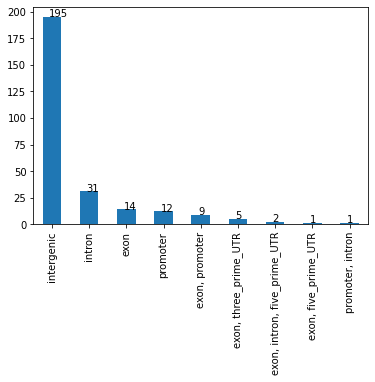

In [106]:
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot
ax = df.annotation.value_counts().plot(kind='bar')
x_offset = -0.07
y_offset = 0.15
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for p in ax.patches:
    b = p.get_bbox()
    val = int(b.y1)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
ax
pyplot.savefig('../data/res/mirna_all.png',transparent=True, bbox_inches='tight', pad_inches=0)

In [107]:
df.annotation.value_counts()

intergenic                      195
intron                           31
exon                             14
promoter                         12
exon, promoter                    9
exon, three_prime_UTR             5
exon, intron, five_prime_UTR      2
exon, five_prime_UTR              1
promoter, intron                  1
Name: annotation, dtype: int64

In [108]:
df.annotation.value_counts()['exon'] + df.annotation.value_counts()['intron'] + df.annotation.value_counts()['exon'] + df.annotation.value_counts()['intron']

90

In [109]:
df.to_csv(path_res, sep='\t', index=None)
print(len(df.index))
print(path_res)

270
../data/res/all_results.csv


In [110]:
# SAVE CURRENT STATE
df.to_csv('../data/res/checkpoint4.csv', index=None)
print(len(df.index))
df.head(2)

270


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,24,seqname,position,start,end,MITE,mirbase,annotation,NEW_NAME,genes
0,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,...,14,1A,117385432-117385825,117385432,117385825,MITE_524,,intergenic,miRNA_MITE_1,
1,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.000,+,UAGAGAUUUCAAAUGGAACAC,7,...,3,1A,169645857-169646029,169645857,169646029,DTT_Tdur_Thalos_103H9-1,,intron,miRNA_MITE_2,TraesCS1A02G130800.1


In [154]:
# LOAD PREVIOUS STATE
df = pd.read_csv('../data/res/checkpoint4.csv')
print(len(df.index))
df.head(2)

270


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,24,seqname,position,start,end,MITE,mirbase,annotation,NEW_NAME,genes
0,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,...,14,1A,117385432-117385825,117385432,117385825,MITE_524,NaN,intergenic,miRNA_MITE_1,NaN
1,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.000,+,UAGAGAUUUCAAAUGGAACAC,7,...,3,1A,169645857-169646029,169645857,169646029,DTT_Tdur_Thalos_103H9-1,NaN,intron,miRNA_MITE_2,TraesCS1A02G130800.1


In [155]:
df.to_csv(path_res, sep='\t', index=None)
print(len(df.index))
print(path_res)

270
../data/res/all_results.csv


In [156]:
df.head(1)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,24,seqname,position,start,end,MITE,mirbase,annotation,NEW_NAME,genes
0,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,...,14,1A,117385432-117385825,117385432,117385825,MITE_524,NaN,intergenic,miRNA_MITE_1,NaN


In [157]:
import numpy as np
df['NEW_NAME'] = ''
df = df.replace(np.nan, '', regex=True)
i = 1
locus = 'nana'
for k,v in df.iterrows():

    if str(v['MITE']) !='':
        df.loc[k, 'NEW_NAME'] = 'miRNA_MITE_{}'.format(i)
    if v['#Locus'] != locus and str(v['MITE']) != '':
        i += 1


In [158]:
df.to_csv(path_res, sep='\t', index=None)
print(len(df.index))
print(path_res)

270
../data/res/all_results.csv


In [159]:
#let's have some fun with data

len(df[df.MITE.isnull()].index)

0

In [117]:

len(df[df.MITE.notnull()].index)

270

In [118]:
df[df.MITE.notnull()].annotation.value_counts()

intergenic                      195
intron                           31
exon                             14
promoter                         12
exon, promoter                    9
exon, three_prime_UTR             5
exon, intron, five_prime_UTR      2
exon, five_prime_UTR              1
promoter, intron                  1
Name: annotation, dtype: int64

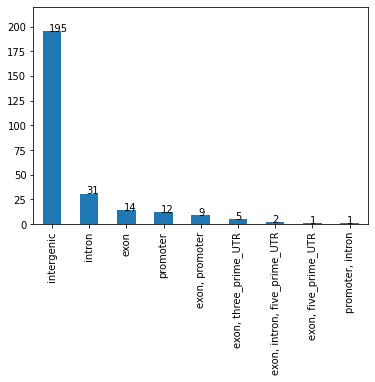

In [119]:
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot
ax = df.annotation.value_counts().plot(kind='bar')
x_offset = -0.07
y_offset = 0.15
ax.set_ylim(0,220)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for p in ax.patches:
    b = p.get_bbox()
    val = int(b.y1)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
ax
pyplot.savefig('../data/res/mirna_mite.png',transparent=True, bbox_inches='tight', pad_inches=0)

In [ ]:
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot
ax = df[df.MITE.notnull()].annotation.value_counts().plot(kind='bar')
x_offset = -0.07
y_offset = 0.15
ax.set_ylim(0,20)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for p in ax.patches:
    b = p.get_bbox()
    val = int(b.y1)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
ax
pyplot.savefig('../data/res/mirna_mite.png',transparent=True, bbox_inches='tight', pad_inches=0)

In [121]:
len(df.index)

270

In [122]:
print(len(df[df.MITE.notnull()].index))
df[df.MITE.notnull()]

270


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,24,seqname,position,start,end,MITE,mirbase,annotation,NEW_NAME,genes
0,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,...,14,1A,117385432-117385825,117385432,117385825,MITE_524,,intergenic,miRNA_MITE_1,
1,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.000,+,UAGAGAUUUCAAAUGGAACAC,7,...,3,1A,169645857-169646029,169645857,169646029,DTT_Tdur_Thalos_103H9-1,,intron,miRNA_MITE_2,TraesCS1A02G130800.1
2,1A:309399489-309399664,mrcv_all_Cluster_872_1A_309399489_309399664,176,553,4.340,1,0.002,-,ACGGCAUAGAGGCACUGCAAA,327,...,4,1A,309399489-309399664,309399489,309399664,,,intergenic,,
3,1A:419025472-419025570,mrcv_all_Cluster_1015_1A_419025472_419025570,99,384,3.014,20,1.000,+,CGAAUGUAUUUUUUAUGGCUUG,249,...,2,1A,419025472-419025570,419025472,419025570,,,intergenic,,
4,1A:492271825-492271935,mrcv_all_Cluster_1205_1A_492271825_492271935,111,79,0.620,40,1.000,+,UGUGCCUGCUCUUCCUCGUCGC,18,...,0,1A,492271825-492271935,492271825,492271935,,,exon,,TraesCS1A02G297400.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,7D:150757019-150757086,sun_all_Cluster_148407_7D_150757019_150757086,68,489,3.872,0,0.998,+,GCGAAGGAUUUGCAGAUACUC,409,...,7,7D,150757019-150757086,150757019,150757086,,,promoter,,TraesCS7D02G193700
266,7D:518678966-518679858,sun_all_Cluster_151125_7D_518678966_518679858,893,3884,30.756,3297,0.006,-,AGCAUGUAGAAACCUAAAUUACGG,2718,...,3455,7D,518678966-518679858,518678966,518679858,,,intergenic,,
267,Un:3685091-3685248,sun_all_Cluster_153682_Un_3685091_3685248,158,586,4.640,288,1.000,+,AGCGCUACCGACGCUGCCCGGACA,179,...,320,Un,3685091-3685248,3685091,3685248,,,intergenic,,
268,Un:31860951-31861093,mrcv_all_Cluster_37718_Un_31860951_31861093,143,208,1.632,6,0.995,+,UAGCCAAGAAUGACUUGCCUG,180,...,1,Un,31860951-31861093,31860951,31861093,,bdi-miR169d,intergenic,,


In [123]:
#list(df[df.MITE.notnull()].MITE.unique())

In [124]:
df[(df.MITE.notnull()) & (df.mirbase.notnull())]

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,24,seqname,position,start,end,MITE,mirbase,annotation,NEW_NAME,genes
0,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,...,14,1A,117385432-117385825,117385432,117385825,MITE_524,,intergenic,miRNA_MITE_1,
1,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.000,+,UAGAGAUUUCAAAUGGAACAC,7,...,3,1A,169645857-169646029,169645857,169646029,DTT_Tdur_Thalos_103H9-1,,intron,miRNA_MITE_2,TraesCS1A02G130800.1
2,1A:309399489-309399664,mrcv_all_Cluster_872_1A_309399489_309399664,176,553,4.340,1,0.002,-,ACGGCAUAGAGGCACUGCAAA,327,...,4,1A,309399489-309399664,309399489,309399664,,,intergenic,,
3,1A:419025472-419025570,mrcv_all_Cluster_1015_1A_419025472_419025570,99,384,3.014,20,1.000,+,CGAAUGUAUUUUUUAUGGCUUG,249,...,2,1A,419025472-419025570,419025472,419025570,,,intergenic,,
4,1A:492271825-492271935,mrcv_all_Cluster_1205_1A_492271825_492271935,111,79,0.620,40,1.000,+,UGUGCCUGCUCUUCCUCGUCGC,18,...,0,1A,492271825-492271935,492271825,492271935,,,exon,,TraesCS1A02G297400.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,7D:150757019-150757086,sun_all_Cluster_148407_7D_150757019_150757086,68,489,3.872,0,0.998,+,GCGAAGGAUUUGCAGAUACUC,409,...,7,7D,150757019-150757086,150757019,150757086,,,promoter,,TraesCS7D02G193700
266,7D:518678966-518679858,sun_all_Cluster_151125_7D_518678966_518679858,893,3884,30.756,3297,0.006,-,AGCAUGUAGAAACCUAAAUUACGG,2718,...,3455,7D,518678966-518679858,518678966,518679858,,,intergenic,,
267,Un:3685091-3685248,sun_all_Cluster_153682_Un_3685091_3685248,158,586,4.640,288,1.000,+,AGCGCUACCGACGCUGCCCGGACA,179,...,320,Un,3685091-3685248,3685091,3685248,,,intergenic,,
268,Un:31860951-31861093,mrcv_all_Cluster_37718_Un_31860951_31861093,143,208,1.632,6,0.995,+,UAGCCAAGAAUGACUUGCCUG,180,...,1,Un,31860951-31861093,31860951,31861093,,bdi-miR169d,intergenic,,


In [125]:
df[df.MITE.notnull()][['#Locus','Name','MajorRNA','MITE','annotation','mirbase']]

,#Locus,Name,MajorRNA,MITE,annotation,mirbase
0,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,UCUGCACCCUGAAUGAUGAAUAGU,MITE_524,intergenic,
1,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,UAGAGAUUUCAAAUGGAACAC,DTT_Tdur_Thalos_103H9-1,intron,
2,1A:309399489-309399664,mrcv_all_Cluster_872_1A_309399489_309399664,ACGGCAUAGAGGCACUGCAAA,,intergenic,
3,1A:419025472-419025570,mrcv_all_Cluster_1015_1A_419025472_419025570,CGAAUGUAUUUUUUAUGGCUUG,,intergenic,
4,1A:492271825-492271935,mrcv_all_Cluster_1205_1A_492271825_492271935,UGUGCCUGCUCUUCCUCGUCGC,,exon,
...,...,...,...,...,...,...
265,7D:150757019-150757086,sun_all_Cluster_148407_7D_150757019_150757086,GCGAAGGAUUUGCAGAUACUC,,promoter,
266,7D:518678966-518679858,sun_all_Cluster_151125_7D_518678966_518679858,AGCAUGUAGAAACCUAAAUUACGG,,intergenic,
267,Un:3685091-3685248,sun_all_Cluster_153682_Un_3685091_3685248,AGCGCUACCGACGCUGCCCGGACA,,intergenic,
268,Un:31860951-31861093,mrcv_all_Cluster_37718_Un_31860951_31861093,UAGCCAAGAAUGACUUGCCUG,,intergenic,bdi-miR169d


In [126]:
df.to_csv(path_res, sep='\t', index=None)
print(len(df.index))
print(path_res)

270
../data/res/all_results.csv


In [127]:
df.head(2)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,24,seqname,position,start,end,MITE,mirbase,annotation,NEW_NAME,genes
0,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,...,14,1A,117385432-117385825,117385432,117385825,MITE_524,,intergenic,miRNA_MITE_1,
1,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.000,+,UAGAGAUUUCAAAUGGAACAC,7,...,3,1A,169645857-169646029,169645857,169646029,DTT_Tdur_Thalos_103H9-1,,intron,miRNA_MITE_2,TraesCS1A02G130800.1


In [128]:
df.columns

Index(['#Locus', 'Name', 'Length', 'Reads', 'RPM', 'UniqueReads', 'FracTop',
       'Strand', 'MajorRNA', 'MajorRNAReads', 'Complexity', 'DicerCall',
       'MIRNA', 'PhaseScore', 'Short', 'Long', '20', '21', '22', '23', '24',
       'seqname', 'position', 'start', 'end', 'MITE', 'mirbase', 'annotation',
       'NEW_NAME', 'genes'],
      dtype='object')

In [137]:
df[df.MITE.notnull()]

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,24,seqname,position,start,end,MITE,mirbase,annotation,NEW_NAME,genes
0,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,...,14,1A,117385432-117385825,117385432,117385825,MITE_524,,intergenic,miRNA_MITE_1,
1,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.000,+,UAGAGAUUUCAAAUGGAACAC,7,...,3,1A,169645857-169646029,169645857,169646029,DTT_Tdur_Thalos_103H9-1,,intron,miRNA_MITE_2,TraesCS1A02G130800.1
2,1A:309399489-309399664,mrcv_all_Cluster_872_1A_309399489_309399664,176,553,4.340,1,0.002,-,ACGGCAUAGAGGCACUGCAAA,327,...,4,1A,309399489-309399664,309399489,309399664,,,intergenic,,
3,1A:419025472-419025570,mrcv_all_Cluster_1015_1A_419025472_419025570,99,384,3.014,20,1.000,+,CGAAUGUAUUUUUUAUGGCUUG,249,...,2,1A,419025472-419025570,419025472,419025570,,,intergenic,,
4,1A:492271825-492271935,mrcv_all_Cluster_1205_1A_492271825_492271935,111,79,0.620,40,1.000,+,UGUGCCUGCUCUUCCUCGUCGC,18,...,0,1A,492271825-492271935,492271825,492271935,,,exon,,TraesCS1A02G297400.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,7D:150757019-150757086,sun_all_Cluster_148407_7D_150757019_150757086,68,489,3.872,0,0.998,+,GCGAAGGAUUUGCAGAUACUC,409,...,7,7D,150757019-150757086,150757019,150757086,,,promoter,,TraesCS7D02G193700
266,7D:518678966-518679858,sun_all_Cluster_151125_7D_518678966_518679858,893,3884,30.756,3297,0.006,-,AGCAUGUAGAAACCUAAAUUACGG,2718,...,3455,7D,518678966-518679858,518678966,518679858,,,intergenic,,
267,Un:3685091-3685248,sun_all_Cluster_153682_Un_3685091_3685248,158,586,4.640,288,1.000,+,AGCGCUACCGACGCUGCCCGGACA,179,...,320,Un,3685091-3685248,3685091,3685248,,,intergenic,,
268,Un:31860951-31861093,mrcv_all_Cluster_37718_Un_31860951_31861093,143,208,1.632,6,0.995,+,UAGCCAAGAAUGACUUGCCUG,180,...,1,Un,31860951-31861093,31860951,31861093,,bdi-miR169d,intergenic,,


In [160]:
df_ = df[df['MITE'] != ''][['NEW_NAME','#Locus','Strand','MajorRNA','DicerCall','MITE','mirbase','annotation','genes']]
df_.columns = ['miRNA name','Locus','Strand','miRNA sequence','Size','MITE','mirbase','annotation','Genes']
df_.to_csv('../data/res/latex_1.csv', sep='&', index=None)


In [130]:
df[df.duplicated(['MajorRNA'],keep=False)]

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,24,seqname,position,start,end,MITE,mirbase,annotation,NEW_NAME,genes
2,1A:309399489-309399664,mrcv_all_Cluster_872_1A_309399489_309399664,176,553,4.340,1,0.002,-,ACGGCAUAGAGGCACUGCAAA,327,...,4,1A,309399489-309399664,309399489,309399664,,,intergenic,,
7,1B:341933649-341933813,sun_all_Cluster_9753_1B_341933649_341933813,165,1101,8.718,9,0.994,+,ACGGCAUAGAGGCACUGCAAA,497,...,7,1B,341933649-341933813,341933649,341933813,,,intergenic,,
9,1B:357916189-357916332,mrcv_all_Cluster_2061_1B_357916189_357916332,144,47078,369.484,1,0.000,-,UCGGACCAGGCUUCAUUCCCC,46159,...,2,1B,357916189-357916332,357916189,357916332,,aof-miR166d,exon,,ENSRNA050017309-T1
13,1D:236440790-236441043,sun_all_Cluster_16553_1D_236440790_236441043,254,1891,14.974,20,0.994,+,ACGGCAUAGAGGCACUGCAAA,1043,...,19,1D,236440790-236441043,236440790,236441043,,,intergenic,,
22,2A:149238439-149238616,mrcv_all_Cluster_5493_2A_149238439_149238616,178,2470,19.385,42,0.001,-,AUCAGGAGAGAUGACACCGAC,1936,...,116,2A,149238439-149238616,149238439,149238616,,osa-miR1432-5p,intergenic,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,7B:725693282-725693358,sun_all_Cluster_144800_7B_725693282_725693358,77,10075,79.780,1,1.000,+,UCUGGCGAGGGACAUACACUGU,9392,...,36,7B,725693282-725693358,725693282,725693358,,tae-miR9678-3p,intergenic,,
263,7D:67105298-67105387,mrcv_all_Cluster_35781_7D_67105298_67105387,90,1627,12.769,13,1.000,+,UGUAGAUACUCCCUAAGGCUU,1291,...,4,7D,67105298-67105387,67105298,67105387,,tae-miR5200,intergenic,,
264,7D:68403780-68403911,mrcv_all_Cluster_35783_7D_68403780_68403911,132,834,6.546,8,0.994,+,UGUAGAUACUCCCUAAGGCUU,793,...,3,7D,68403780-68403911,68403780,68403911,,tae-miR5200,intergenic,,
265,7D:150757019-150757086,sun_all_Cluster_148407_7D_150757019_150757086,68,489,3.872,0,0.998,+,GCGAAGGAUUUGCAGAUACUC,409,...,7,7D,150757019-150757086,150757019,150757086,,,promoter,,TraesCS7D02G193700


In [131]:
df[df.duplicated(['Name'],keep=False)]

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,24,seqname,position,start,end,MITE,mirbase,annotation,NEW_NAME,genes
